In [8]:
from aws_helper_functions import aws_helper_functions
import pandas as pd
import numpy as np
from sklearn.neighbors import BallTree
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
import tensorflow as tf
import seaborn as sns

In [17]:
def _get_table_data(basetable=''):
    raw_basetable = pd.read_csv(basetable)
    df = raw_basetable
    df = df[~df['grade'].isin(['PK', 'Not In School'])]
    df = df[~df['grade'].isnull()]
    df['scholar_grade'] = np.where(df['grade']=='K','0',df['grade']).astype(int)
    df['latitude'] = df['students_home__latitude__s']
    df['longitude'] = df['students_home__longitude__s']
    df['school'] = df['accepted_school']
    df = _get_commute_time(_retrieve_nearest_census_tract_numbers(df,local_mode=True),local_mode=True)
    df['intercept'] = 1
    df['es_school'] = df['scholar_grade'].isin(np.arange(0,5)).astype(int)
    df['ms_school'] = df['scholar_grade'].isin(np.arange(5,6)).astype(int)
    df['log_commute'] = np.log(df['commute_time'])
    df['log_commute_square'] = df['log_commute'] ** 2
    df['log_commute_third'] = df['log_commute'] ** 3
    df = df[['intercept','yield','uniform_ordered','accepted_first_rank','had_enrolled_sib','ell_status','homeless_status','es_school','ms_school','orientation_rsvp','virtual_event_attended','in_person_event_attended',
            'scholar_grade','commute_time',
            'log_commute','log_commute_square','log_commute_third',
            'school','utm_source_bucketing']]
    df = df.dropna()
    return df

def _read_eval_data(as_of_date, query_name, query_dir, local_mode):
    query_file = query_dir + query_name
    query = open(query_file).read()
    query = query.format(date=as_of_date)
    basetable = aws_helper_functions.read_from_redshift(query, local_mode=local_mode)
    return basetable
    return df

def _retrieve_nearest_census_tract_numbers(df, local_mode=''):
    # retrive census tract information from redshift
    df_census = aws_helper_functions.read_from_redshift('SELECT * FROM raw_data_science.raw_commute_census_tracts_lat_long', local_mode=local_mode)
    # Create a BallTree for the census tract latitudes and longitudes
    tree = BallTree(df_census[['lat_orig', 'long_orig']].values, leaf_size=40)
    
    #drop rows in df where students_home__latitude__s or students_home__longitude__s is null
    #df = df.dropna(subset=['latitude', 'longitude'])
    df['latitude'] = np.where(df['latitude'].isna()==True, 40.776676, df['latitude'])
    df['longitude'] = np.where(df['longitude'].isna()==True, -73.971321, df['longitude'])
    
    distances, indices = tree.query(df[['latitude', 'longitude']].values, k=1)
    df.loc[:, 'boro_int'] = df_census.loc[indices.flatten(), 'boro_int'].values.copy()
    df.loc[:, 'census_tract_int'] = df_census.loc[indices.flatten(), 'census_tract_int'].values.copy()
    return df

def _get_commute_time(df, local_mode=''):
    #retrieve school-census tract commute times from redshift
    df_commutes = aws_helper_functions.read_from_redshift('SELECT * FROM raw_data_science.raw_commute_census_tracts_to_schools', local_mode=local_mode)
    
    schools = _get_schools()
    df_commutes = _replace_with_keys(df_commutes, 'school', schools)
    #set df_commutes.time_walking_min, time_transit_min, and time_driving_min to numeric
    df_commutes['time_walking_min'] = pd.to_numeric(df_commutes['time_walking_min'], errors='coerce')
    df_commutes['time_transit_min'] = pd.to_numeric(df_commutes['time_transit_min'], errors='coerce')
    df_commutes['time_driving_min'] = pd.to_numeric(df_commutes['time_driving_min'], errors='coerce')
    
    df_commutes['commute_time'] = df_commutes[['time_walking_min', 'time_transit_min']].min(axis=1)
    df_commutes = df_commutes[['boro_int', 'census_tract_int', 'school', 'commute_time']]
    
    df = df.merge(df_commutes, how='left', on=['boro_int', 'census_tract_int', 'school'])
    df['commute_time'] = np.where(df['commute_time']>120,30,df['commute_time'])
    return df

def _get_schools():
    schools = {
        'SA Bed-Stuy 2': 'BED-STUY2',
        'SA Bed-Stuy': 'BED-STUY2',
        'SA Bed-Stuy Middle School': 'BED-STUY_MIDDLE_SCHOOL',
        'SA Bensonhurst': 'BENSONHURST',
        'SA Bergen Beach':'BERGEN_BEACH',
        'SA Bronx 1 Middle School': 'BRONX1',
        'SA Bronx 1': 'BRONX1',
        'SA Bronx Middle School': 'BRONX_MIDDLE_SCHOOL',
        'SA Bronx 2': 'BRONX2',
        'SA Bronx 2 Middle School': 'BRONX2_MIDDLE_SCHOOL',
        'SA Bronx 3': 'BRONX3',
        'SA Bronx 4': 'BRONX4',
        'SA Bronx 5': 'BRONX5',
        'SA Bronx 5 Upper': 'BRONX5',
        'SA Bronx 5 Lower': 'BRONX5',
        'SA Bushwick': 'BUSHWICK',
        'SA Cobble Hill': 'COBBLE_HILL',
        'SA Crown Heights': 'CROWN_HEIGHTS',
        'SA Ditmas Park Middle School': 'DITMAS_PARK_MIDDLE_SCHOOL',
        'SA East Flatbush Middle School': 'EAST_FLATBUSH_MIDDLE_SCHOOL',
        'SA Far Rockaway': 'FAR_ROCKAWAY',
        'SA Far Rockaway Middle School': 'FAR_ROCKAWAY_MIDDLE_SCHOOL',
        'SA Flatbush': 'FLATBUSH',
        'SA Hamilton Heights Middle School': 'HARLEM6',
        'SA Harlem 1': 'HARLEM1',
        'SA Harlem 2': 'HARLEM2',
        'SA Harlem 3': 'HARLEM3',
        'SA Harlem 4': 'HARLEM4',
        'SA Harlem 5': 'HARLEM5',
        'SA Harlem 6': 'HARLEM6',
        'SA Harlem East': 'HARLEM_EAST',
        'SA Harlem East Middle School': 'HARLEM_EAST',
        'SA Harlem North Central': 'HARLEM_NORTH_CENTRAL',
        'SA Harlem North Central Middle School': 'HARLEM_NORTH_CENTRAL',
        'SA Harlem West': 'HARLEM_WEST',
        'SA Harlem West Middle School': 'HARLEM_WEST',
        'SA Harlem North West': 'HARLEM_NORTH_WEST',
        'SA Harlem North West Middle School': 'HARLEM_NORTH_WEST',
        'SA Hells Kitchen': 'HELLS_KITCHEN',
        'SA Hell\'s Kitchen': 'HELLS_KITCHEN',
        'SA High School of the Liberal Arts - Manhattan': 'HIGH_SCHOOL_OF_THE_LIBERAL_ARTS_-_MANHATTAN',
        'SA High School of the Liberal Arts-Manhattan': 'HIGH_SCHOOL_OF_THE_LIBERAL_ARTS_-_MANHATTAN',
        'SA High School of the Liberal Arts - Harlem': 'HIGH_SCHOOL_OF_THE_LIBERAL_ARTS_-_HARLEM',
        'SA High School of the Liberal Arts-Harlem': 'HIGH_SCHOOL_OF_THE_LIBERAL_ARTS_-_HARLEM',
        'SA High School of the Liberal Arts - Brooklyn': 'HIGH_SCHOOL_OF_THE_LIBERAL_ARTS_-_BROOKLYN',
        'SA High School of the Liberal Arts-Brooklyn': 'HIGH_SCHOOL_OF_THE_LIBERAL_ARTS_-_BROOKLYN',
        'SA Hudson Yards': 'HUDSON_YARDS',
        'SA Hudson Yards Middle School': 'HUDSON_YARDS_MIDDLE_SCHOOL',
        'SA Kingsbridge Heights': 'KINGSBRIDGE_HEIGHTS',
        'SA Lafayette Middle School': 'LAFAYETTE_MIDDLE_SCHOOL',
        'SA Midtown West Middle School': 'MIDTOWN_WEST',
        'SA Myrtle Middle School': 'MYRTLE_MIDDLE_SCHOOL',
        'SA Norwood': 'NORWOOD',
        'SA Ozone Park Middle School': 'OZONE_PARK_MIDDLE_SCHOOL',
        'SA Prospect Heights': 'PROSPECT_HEIGHTS',
        'SA Queens Village': 'QUEENS_VILLAGE',
        'SA Rosedale': 'ROSEDALE',
        'SA Rockaway Park Middle School': 'ROCKAWAY_PARK_MIDDLE_SCHOOL',
        'SA South Jamaica': 'SOUTH_JAMAICA',
        'SA Sheepshead Bay': 'SHEEPSHEAD_BAY',
        'SA Springfield Gardens Middle School': 'SPRINGFIELD_GARDENS',
        'SA Springfield Gardens MS': 'SPRINGFIELD_GARDENS',
        'SA Springfield Gardens': 'SPRINGFIELD_GARDENS',
        'SA Union Square': 'UNION_SQUARE',
        'SA Upper West': 'UPPER_WEST',
        'SA Washington Heights': 'WASHINGTON_HEIGHTS',
        'SA Williamsburg': 'WILLIAMSBURG',
        }
    return schools

def _replace_with_keys(df, column, dictionary):
    new_df = pd.DataFrame()
    for key, value in dictionary.items():
        temp_df = df[df[column] == value].copy()
        temp_df[column] = key
        new_df = pd.concat([new_df, temp_df])
    return new_df

def set_predictors(current_predictors):
    predictors = current_predictors
    return predictors

def set_target(current_target):
    target = current_target
    return target

def setup_training_data(df, predictors, target):
    X = df[predictors]
    Y = df[target]
    return X, Y

def _clean_data(basetable):
    dat = pd.DataFrame(basetable)
    dat['school'] = dat['accepted_school'].astype('category')
    dat['scholar_grade'] = dat['grade'].astype('category')
    dat['latitude'] = dat['students_home__latitude__s']
    dat['longitude'] = dat['students_home__longitude__s']
    return dat

def setup_evaluation_data(df, predictors, target):
    df = df.drop(['students_home__latitude__s','students_home__longitude__s','grade','accepted_school'],axis=1).dropna()
    X_eval = df[predictors]
    X_eval['school'] = X_eval['school'].astype('category')
    X_eval['scholar_grade'] = X_eval['scholar_grade'].astype('category')
    return X_eval

In [32]:
# Get data
df_train = _get_table_data('train_basetable.csv')

# Set target and predictors
target = set_target(['yield'])
# predictors = set_predictors(['uniform_ordered','accepted_first_rank','had_enrolled_sib',
#                             'orientation_rsvp','virtual_event_attended','in_person_event_attended',
#                             'scholar_grade','commute_time',
#                             'utm_source_bucketing','school'])
predictors = set_predictors(['accepted_first_rank','had_enrolled_sib',
                            'scholar_grade','commute_time','school'])

# Prepare data
X, y =  setup_training_data(df_train, predictors, target)
# X = pd.get_dummies(X, columns=['utm_source_bucketing','school'])
X = pd.get_dummies(X, columns=['school'])

# Split data for LOO CV
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [39]:
X_train.dtypes

accepted_first_rank                           int64
had_enrolled_sib                              int64
scholar_grade                                 int64
commute_time                                float64
school_SA Bed-Stuy                             bool
school_SA Bensonhurst                          bool
school_SA Bergen Beach                         bool
school_SA Bronx 1                              bool
school_SA Bronx 1 Middle School                bool
school_SA Bronx 2                              bool
school_SA Bronx 3                              bool
school_SA Bronx 4                              bool
school_SA Bronx 5                              bool
school_SA Bushwick                             bool
school_SA Cobble Hill                          bool
school_SA Crown Heights                        bool
school_SA Ditmas Park Middle School            bool
school_SA Far Rockaway                         bool
school_SA Flatbush                             bool
school_SA Ha

Epoch 1/100
482/482 ━━━━━━━━━━━━━━━━━━━━ 1s 437us/step - accuracy: 0.7432 - loss: 0.5527
Epoch 2/100
482/482 ━━━━━━━━━━━━━━━━━━━━ 0s 453us/step - accuracy: 0.7389 - loss: 0.5524
Epoch 3/100
482/482 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step - accuracy: 0.7354 - loss: 0.5556
Epoch 4/100
482/482 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step - accuracy: 0.7386 - loss: 0.5539
Epoch 5/100
482/482 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - accuracy: 0.7386 - loss: 0.5539
Epoch 6/100
482/482 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - accuracy: 0.7400 - loss: 0.5501
Epoch 7/100
482/482 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - accuracy: 0.7368 - loss: 0.5515
Epoch 8/100
482/482 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step - accuracy: 0.7375 - loss: 0.5501
Epoch 9/100
482/482 ━━━━━━━━━━━━━━━━━━━━ 0s 459us/step - accuracy: 0.7399 - loss: 0.5502
Epoch 10/100
482/482 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - accuracy: 0.7375 - loss: 0.5484
Epoch 11/100
482/482 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step - accuracy: 0.7413 - loss: 0.5481
Epoch 12/100
482/48

<Axes: ylabel='Density'>

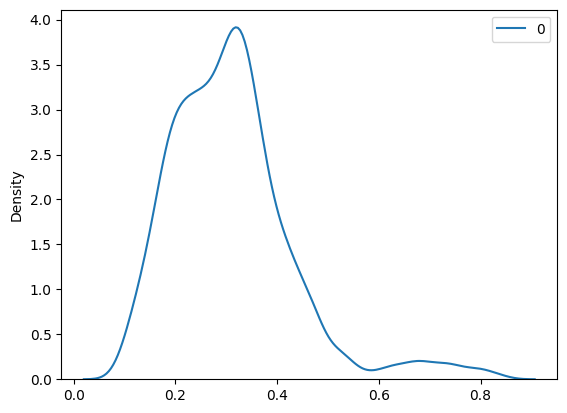

In [33]:
# Set up sequential model (as opposed to functional model) and define it's layers
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Define loss function, optimizer, and metrics to show during epochs
loss_bce = tf.keras.losses.BinaryCrossentropy()
optimizer_sgd = tf.keras.optimizers.SGD(learning_rate=0.001)
metric_ba = tf.keras.metrics.BinaryAccuracy(name='accuracy')

# Compile model
model.compile(
    loss = loss_bce,
    optimizer = optimizer_sgd,
    metrics = [
        metric_ba
    ]
)

# Define number of callbacks as epochs (they function the same as iterations/chains)
history = model.fit(X_train, y_train, epochs=100)

# Calculate prediction probabilities
predictions_test = model.predict(X_test)

# Calculate binary predictions from probabilities
prediction_test_classes = [
    1 if prob > 0.5 else 0 for prob in np.ravel(predictions)
]

# Print final results for LOO CV
print(confusion_matrix(y_test, prediction_test_classes))
print(f'Accuracy: {accuracy_score(y_test, prediction_test_classes):.2f}')
sns.kdeplot(predictions_test)

In [63]:
dat_raw =  _read_eval_data(as_of_date='2024-04-04',query_dir='/Users/kenny.mai/Documents/yield_forecast/edna-data-science-talend-models/yield_dev/',query_name='eval_basetable.sql',local_mode=True)
dat =  _clean_data(dat_raw)
df =  _get_commute_time(_retrieve_nearest_census_tract_numbers(dat,local_mode=True),local_mode=True)
df['commute_time'] = np.where(df['commute_time'].isna(),30,df['commute_time'])
df['scholar_grade'] = np.where(df['grade']=='K','0',df['grade']).astype(int)
df = df[predictors]
df = pd.get_dummies(df, columns=['school'])

In [71]:
df.columns

Index(['accepted_first_rank', 'had_enrolled_sib', 'scholar_grade',
       'commute_time', 'school_SA Bed-Stuy',
       'school_SA Bed-Stuy Middle School', 'school_SA Bensonhurst',
       'school_SA Bergen Beach', 'school_SA Bronx 1',
       'school_SA Bronx 1 Middle School', 'school_SA Bronx 2',
       'school_SA Bronx 3', 'school_SA Bronx 4', 'school_SA Bronx 5',
       'school_SA Bushwick', 'school_SA Cobble Hill',
       'school_SA Crown Heights', 'school_SA Ditmas Park Middle School',
       'school_SA Far Rockaway', 'school_SA Flatbush',
       'school_SA Hamilton Heights Middle School', 'school_SA Harlem 1',
       'school_SA Harlem 2', 'school_SA Harlem 3', 'school_SA Harlem 4',
       'school_SA Harlem 5', 'school_SA Harlem East', 'school_SA Harlem West',
       'school_SA Hell's Kitchen', 'school_SA Hudson Yards',
       'school_SA Kingsbridge Heights', 'school_SA Norwood',
       'school_SA Prospect Heights', 'school_SA Queens Village',
       'school_SA Rockaway Park Middle 

In [72]:
X_train.columns

Index(['accepted_first_rank', 'had_enrolled_sib', 'scholar_grade',
       'commute_time', 'school_SA Bed-Stuy', 'school_SA Bensonhurst',
       'school_SA Bergen Beach', 'school_SA Bronx 1',
       'school_SA Bronx 1 Middle School', 'school_SA Bronx 2',
       'school_SA Bronx 3', 'school_SA Bronx 4', 'school_SA Bronx 5',
       'school_SA Bushwick', 'school_SA Cobble Hill',
       'school_SA Crown Heights', 'school_SA Ditmas Park Middle School',
       'school_SA Far Rockaway', 'school_SA Flatbush',
       'school_SA Hamilton Heights Middle School', 'school_SA Harlem 1',
       'school_SA Harlem 2', 'school_SA Harlem 3', 'school_SA Harlem 4',
       'school_SA Harlem 5', 'school_SA Harlem 6', 'school_SA Harlem East',
       'school_SA Hell's Kitchen', 'school_SA Hudson Yards',
       'school_SA Norwood', 'school_SA Ozone Park Middle School',
       'school_SA Prospect Heights', 'school_SA Queens Village',
       'school_SA Rosedale', 'school_SA Sheepshead Bay',
       'school_SA South

In [66]:
predictions = model.predict(df)

# Calculate binary predictions from probabilities
prediction_classes = [
    1 if prob > 0.5 else 0 for prob in np.ravel(predictions)
]

# Print final results for LOO CV
sns.kdeplot(predictions)

2024-04-04 09:29:42.723009: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: Matrix size-incompatible: In[0]: [32,45], In[1]: [41,64]
	 [[{{node sequential_3_1/dense_15_1/MatMul}}]]


InvalidArgumentError: Graph execution error:

Detected at node sequential_3_1/dense_15_1/MatMul defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/Users/kenny.mai/Documents/yield_forecast/edna-data-science-talend-models/yield_dev/.venv/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/Users/kenny.mai/Documents/yield_forecast/edna-data-science-talend-models/yield_dev/.venv/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/Users/kenny.mai/Documents/yield_forecast/edna-data-science-talend-models/yield_dev/.venv/lib/python3.12/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/Users/kenny.mai/Documents/yield_forecast/edna-data-science-talend-models/yield_dev/.venv/lib/python3.12/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/base_events.py", line 639, in run_forever

  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/base_events.py", line 1985, in _run_once

  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py", line 88, in _run

  File "/Users/kenny.mai/Documents/yield_forecast/edna-data-science-talend-models/yield_dev/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/Users/kenny.mai/Documents/yield_forecast/edna-data-science-talend-models/yield_dev/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/Users/kenny.mai/Documents/yield_forecast/edna-data-science-talend-models/yield_dev/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/Users/kenny.mai/Documents/yield_forecast/edna-data-science-talend-models/yield_dev/.venv/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 359, in execute_request

  File "/Users/kenny.mai/Documents/yield_forecast/edna-data-science-talend-models/yield_dev/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/Users/kenny.mai/Documents/yield_forecast/edna-data-science-talend-models/yield_dev/.venv/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 446, in do_execute

  File "/Users/kenny.mai/Documents/yield_forecast/edna-data-science-talend-models/yield_dev/.venv/lib/python3.12/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/Users/kenny.mai/Documents/yield_forecast/edna-data-science-talend-models/yield_dev/.venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/Users/kenny.mai/Documents/yield_forecast/edna-data-science-talend-models/yield_dev/.venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/Users/kenny.mai/Documents/yield_forecast/edna-data-science-talend-models/yield_dev/.venv/lib/python3.12/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/Users/kenny.mai/Documents/yield_forecast/edna-data-science-talend-models/yield_dev/.venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/Users/kenny.mai/Documents/yield_forecast/edna-data-science-talend-models/yield_dev/.venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/Users/kenny.mai/Documents/yield_forecast/edna-data-science-talend-models/yield_dev/.venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/var/folders/d7/jj2l6jk97k76q08_jpr5mrgh0000gq/T/ipykernel_84089/3521941085.py", line 1, in <module>

  File "/Users/kenny.mai/Documents/yield_forecast/edna-data-science-talend-models/yield_dev/.venv/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/Users/kenny.mai/Documents/yield_forecast/edna-data-science-talend-models/yield_dev/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 519, in predict

  File "/Users/kenny.mai/Documents/yield_forecast/edna-data-science-talend-models/yield_dev/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 217, in one_step_on_data_distributed

  File "/Users/kenny.mai/Documents/yield_forecast/edna-data-science-talend-models/yield_dev/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 206, in one_step_on_data

  File "/Users/kenny.mai/Documents/yield_forecast/edna-data-science-talend-models/yield_dev/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 98, in predict_step

  File "/Users/kenny.mai/Documents/yield_forecast/edna-data-science-talend-models/yield_dev/.venv/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/Users/kenny.mai/Documents/yield_forecast/edna-data-science-talend-models/yield_dev/.venv/lib/python3.12/site-packages/keras/src/layers/layer.py", line 813, in __call__

  File "/Users/kenny.mai/Documents/yield_forecast/edna-data-science-talend-models/yield_dev/.venv/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/Users/kenny.mai/Documents/yield_forecast/edna-data-science-talend-models/yield_dev/.venv/lib/python3.12/site-packages/keras/src/ops/operation.py", line 48, in __call__

  File "/Users/kenny.mai/Documents/yield_forecast/edna-data-science-talend-models/yield_dev/.venv/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/Users/kenny.mai/Documents/yield_forecast/edna-data-science-talend-models/yield_dev/.venv/lib/python3.12/site-packages/keras/src/models/sequential.py", line 202, in call

  File "/Users/kenny.mai/Documents/yield_forecast/edna-data-science-talend-models/yield_dev/.venv/lib/python3.12/site-packages/keras/src/models/functional.py", line 194, in call

  File "/Users/kenny.mai/Documents/yield_forecast/edna-data-science-talend-models/yield_dev/.venv/lib/python3.12/site-packages/keras/src/ops/function.py", line 151, in _run_through_graph

  File "/Users/kenny.mai/Documents/yield_forecast/edna-data-science-talend-models/yield_dev/.venv/lib/python3.12/site-packages/keras/src/models/functional.py", line 578, in call

  File "/Users/kenny.mai/Documents/yield_forecast/edna-data-science-talend-models/yield_dev/.venv/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/Users/kenny.mai/Documents/yield_forecast/edna-data-science-talend-models/yield_dev/.venv/lib/python3.12/site-packages/keras/src/layers/layer.py", line 813, in __call__

  File "/Users/kenny.mai/Documents/yield_forecast/edna-data-science-talend-models/yield_dev/.venv/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/Users/kenny.mai/Documents/yield_forecast/edna-data-science-talend-models/yield_dev/.venv/lib/python3.12/site-packages/keras/src/ops/operation.py", line 48, in __call__

  File "/Users/kenny.mai/Documents/yield_forecast/edna-data-science-talend-models/yield_dev/.venv/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/Users/kenny.mai/Documents/yield_forecast/edna-data-science-talend-models/yield_dev/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py", line 143, in call

  File "/Users/kenny.mai/Documents/yield_forecast/edna-data-science-talend-models/yield_dev/.venv/lib/python3.12/site-packages/keras/src/ops/numpy.py", line 3555, in matmul

  File "/Users/kenny.mai/Documents/yield_forecast/edna-data-science-talend-models/yield_dev/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/numpy.py", line 469, in matmul

Matrix size-incompatible: In[0]: [32,45], In[1]: [41,64]
	 [[{{node sequential_3_1/dense_15_1/MatMul}}]] [Op:__inference_one_step_on_data_distributed_427907]